In [1]:
import os
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
file_name = "ml-100k.zip"

with zipfile.ZipFile(file_name, 'r') as zip_file:
    zip_file.extractall()

In [3]:
def read_data_ml100k():
    data_dir = "ml-100k"
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), sep='\t',
                       names=names, engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [4]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))

number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


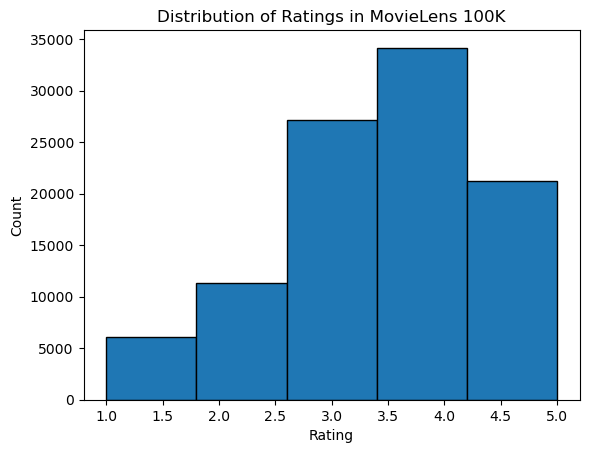

In [5]:
plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings in MovieLens 100K")
plt.show()

In [6]:
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users+1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

In [7]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [8]:
class ArrayDataset(Dataset):
    def __init__(self, u, i, r):
        self.u = u
        self.i = i
        self.r = r
    
    def __len__(self):
        return len(self.u)
    
    def __getitem__(self, idx):
        return (self.u[idx], self.i[idx], self.r[idx])

In [9]:
def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(
        data, num_users, num_items, split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)
    train_set = ArrayDataset(
        np.array(train_u), np.array(train_i), np.array(train_r))
    test_set = ArrayDataset(
        np.array(test_u), np.array(test_i), np.array(test_r))
    train_iter = DataLoader(
        train_set, shuffle=True, batch_size=batch_size)
    test_iter = DataLoader(
        test_set, batch_size=batch_size)
    return num_users, num_items, train_iter, test_iter

In [10]:
num_users, num_items, train_iter, test_iter = split_and_load_ml100k()

In [11]:
next(iter(train_iter))

[tensor([626, 176, 458,  81, 177, 711, 278, 166, 229, 698, 525, 709, 436, 408,
         884, 116, 261, 718, 633, 343, 290, 333, 269, 711, 384,  25,  77,  89,
         216,   7,  58,  67, 585, 845, 312, 404, 669, 206, 513, 451, 284,   4,
         496,  63,   6, 626, 832,  93, 499,  84, 140, 322,  12, 875, 362, 518,
          49, 405, 785, 683, 493, 720, 879, 657, 248, 878, 884, 360, 496, 222,
         114, 307, 194, 298,  81, 406, 889, 887, 333, 817, 880, 488,   6,  58,
         556, 243, 834, 641, 312, 395, 364, 235, 681, 642, 406, 342, 188, 689,
          11, 550, 404,   0, 523, 607, 415, 161, 404, 536, 149, 535, 737, 398,
         456,  12,   5, 902,   6, 597, 505, 192, 436, 794, 428, 463, 879, 621,
         715, 901, 832, 379, 926,  94, 743, 278, 505, 331, 526, 787, 451,  12,
         294,  12, 772,  94, 200, 455, 692, 523, 262, 470, 287, 708, 144, 880,
         416, 129, 804, 933, 926, 283, 756, 449, 585, 379, 342, 786, 457,  14,
         681, 649, 200, 221, 457, 715, 424,  90, 386